In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision, torchvision.transforms as transforms

import torchvision.models as models
from torchvision.utils import make_grid

from skimage.color import lab2rgb, rgb2lab
from tqdm.notebook import tqdm
import copy

In [2]:
cuda_num=3
device = f'cuda:{cuda_num}' if torch.cuda.is_available() else 'cpu'

Загрузка предобученного классификатора для подсчета лосса и части предобученного классификатора без верхних слоев (этими весами будет инициализирован генератор).

In [3]:
vgg16 = models.vgg16(pretrained=True).to(device)

In [4]:
vgg16_cut = copy.deepcopy(vgg16).features[:-8].to(device)

In [5]:
torch.manual_seed(42)

Загружаем и обрабатываем датасет

In [6]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor()
])

In [7]:
train_dataset = torchvision.datasets.ImageFolder('../../../../data/evdmsivets/tiny-imagenet-200/train', transform=transforms)
test_dataset = torchvision.datasets.ImageFolder('../../../../data/evdmsivets/tiny-imagenet-200/val',
                                                transform=transforms)

In [8]:
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=15)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=15)

Загрузка архитектуры модели, необходимых вспомогательных функций

In [9]:
from model import Generator, Discriminator, Generator_1, Generator_2, Block

In [10]:
from utils import kl_divergence, compute_gradient_penalty, rgb_to_lab, lab_to_rgb, compute_psnr

Построение соответствия между классами TinyImageNet и ImageNet

In [18]:
file = open('200_wnids.txt', 'r')
 
tiny_labels = []
for line in file:
    tiny_labels.append(line.strip())

In [19]:
file = open('imagenet1000_clsid_to_labels.txt', 'r')

imagenet_labels_dict = {}
index = 0
for line in file:
    imagenet_labels_dict[line.split()[0][:-1]] = index
    index += 1

In [20]:
tiny_idx = []
for elem in tiny_labels:
    if elem in imagenet_labels_dict:
        tiny_idx.append(imagenet_labels_dict[elem])

In [22]:
import neptune

In [23]:
NEPTUNE_API_TOKEN="sometoken"

In [24]:
neptune.init(f'calistro/chromagan', api_token=NEPTUNE_API_TOKEN)

Project(calistro/chromagan)

In [26]:
neptune.create_experiment(name='exp3_3')

https://ui.neptune.ai/calistro/chromagan/e/CHROM-15


Experiment(CHROM-15)

Обучение модели.

In [ ]:
lambda_gp = 10
lambda_adv = 0.1
lambda_clf = 0.003

n_epochs = 3

G = Generator(vgg16_cut).to(device)
D = Discriminator().to(device)

g_optimizer = torch.optim.Adam(G.parameters(), lr=0.00002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.00002, betas=(0.5, 0.999))

with tqdm(total=n_epochs*len(train_loader), desc=f"[D loss: ?] [G loss: ?]") as pbar:
    for epoch in range(n_epochs):
        vgg16.eval()
        vgg16_cut.train()
        G.train()
        for i, (img, label) in enumerate(train_loader):
            lab_img = rgb_to_lab(img).float().to(device)
            L_channel = lab_img[:, 0:1, :, :]
            ab_channel = lab_img[:, 1:, :, :]

            gray_img = torch.cat([L_channel]*3, dim=1)

            gt_vgg_preds = vgg16(gray_img)
            gt_tiny_vgg_preds = F.log_softmax(gt_vgg_preds[:, tiny_idx], dim=-1)
            
            # Discriminator step #
            
            gen_out_ab_channels, clf_logits = G(gray_img)        

            gen_out_img = torch.cat([L_channel, gen_out_ab_channels], dim=1)

            gradient_penalty = compute_gradient_penalty(D, lab_img, gen_out_img)

            d_optimizer.zero_grad()
            real_validity = D(lab_img)
            fake_validity = D(gen_out_img)
            d_adv_loss = - torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

            d_loss = lambda_adv * d_adv_loss
            d_loss.backward()
            d_optimizer.step()

            # Generator step #

            gen_out_ab_channels, clf_logits = G(gray_img)
            gen_out_img = torch.cat([L_channel, gen_out_ab_channels], dim=1)
            fake_validity = D(gen_out_img)

            g_optimizer.zero_grad()

            g_adv_loss = - torch.mean(fake_validity)

            clf_preds = F.log_softmax(clf_logits, dim=-1)
            
            clf_loss = kl_divergence(gt_tiny_vgg_preds, clf_preds)
            color_loss = torch.mean((gen_out_ab_channels - ab_channel)**2)

            g_loss = lambda_clf * clf_loss + color_loss + lambda_adv * g_adv_loss

            g_loss.backward()
            g_optimizer.step()            

            pbar.set_description(f"[D loss: {d_loss.item():.2f}] [G loss: {g_loss.item():.2f}]")
            neptune.log_metric('D_loss', d_loss.item())
            neptune.log_metric('G_loss', g_loss.item())
            pbar.update(1)
        G.eval()
        psnr = []    
        for i, (img, label) in enumerate(test_loader):
            lab_img = rgb_to_lab(img).float().to(device)
            L_channel = lab_img[:, 0:1, :, :]
            ab_channel = lab_img[:, 1:, :, :]

            gray_img = torch.cat([L_channel]*3, dim=1)
            
            gen_out_ab_channels, clf_logits = G(gray_img)
            gen_out_img = torch.cat([L_channel, gen_out_ab_channels], dim=1)
            
            rgb_gen_out_img = lab_to_rgb(gen_out_img)
            
            psnr.append(compute_psnr(rgb_gen_out_img, img))
            
            if (i + 1) % 500 == 0:
                gt = make_grid(img, nrow=5).detach().cpu().permute(1,2,0)
                output = make_grid(rgb_gen_out_img, nrow=5).detach().cpu().permute(1,2,0)
                grayscale = make_grid(gray_img, nrow=5).detach().cpu().permute(1,2,0)

                fig = plt.figure(figsize=(15,15))
                plt.imshow(torch.cat([gt, output, grayscale], dim=0))
                plt.close(fig)
                neptune.log_image('colorization', fig)

        neptune.log_metric('PSNR', np.mean(psnr))
        
        torch.save(G, 'generator.pt')
        torch.save(D, 'discriminator.pt')
        torch.save(vgg16_cut, 'vgg16_cut.pt')


In [29]:
neptune.stop()

Здесь можно загрузить обученную модель и проверить ее раскрашивание на чб изображении

In [287]:
mymodel = torch.load('generator.pt', map_location=lambda storage, loc: storage)

In [288]:
def colorize_bw_image(img, model): # img HxW

    L_channel = torch.from_numpy(img[None, None]).float()
    gray_img = torch.stack([torch.from_numpy(img)]*3 )[None].float()
    
    gen_out_ab_channels, _ = model(gray_img)
    gen_out_img = torch.cat([L_channel, gen_out_ab_channels], dim=1)

    rgb_gen_out_img = lab_to_rgb(gen_out_img)
    
    return rgb_gen_out_img[0].permute(1,2,0)

Загрузка чб фото, обработка до нужного размера, сохранение для сравнения со сторонними сервисами колоризации.

In [289]:
import skimage.io
from skimage.transform import resize
new_img = skimage.io.imread('img004.jpg')
new_img = resize(new_img, (224, 224))
# skimage.io.imsave('img004_resized.jpg', new_img)

Black-White input


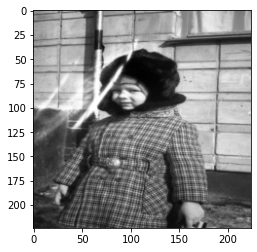

In [290]:
print('Black-White input')
plt.imshow(new_img, cmap='gray')
plt.show()

ChromaGAN Colorized


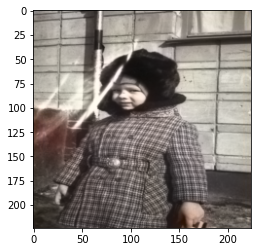

In [291]:
print('ChromaGAN Colorized')
plt.imshow(colorize_bw_image(new_img, mymodel))
plt.show()

https://9may.mail.ru/restoration/

Mail Colorized


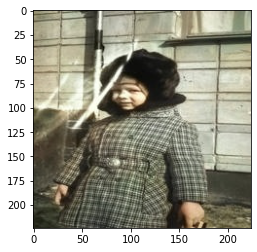

In [292]:
print('Mail Colorized')
new_img = skimage.io.imread('mail_photo.jpg')
plt.imshow(new_img)
plt.show()

Предобработка для тестовых картинок из TinyImagenet

In [304]:
def colorized_imagenet(img, model): # img HxW
    img = img[None]
    lab_img = rgb_to_lab(img).float()

    L_channel = lab_img[:, 0:1, :, :]
    ab_channel = lab_img[:, 1:, :, :]

    gray_img = torch.cat([L_channel]*3, dim=1)
    gen_out_ab_channels, clf_logits = model(gray_img)
    gen_out_img = torch.cat([L_channel, gen_out_ab_channels], dim=1)
    rgb_gen_out_img = lab_to_rgb(gen_out_img)
    return rgb_gen_out_img[0].permute(1,2,0)

Colorized


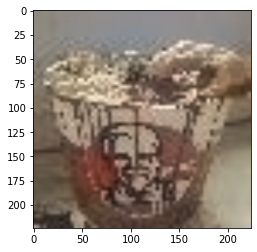

GT


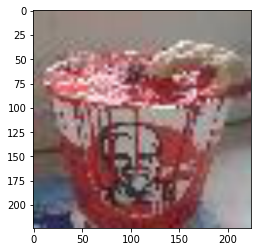

In [305]:
img = test_dataset[4000][0] # any index in TinyImageNet
plt.imshow(colorized_imagenet(img, mymodel))
print('Colorized')
plt.show()
plt.imshow(img.permute(1,2,0))
print('GT')
plt.show()

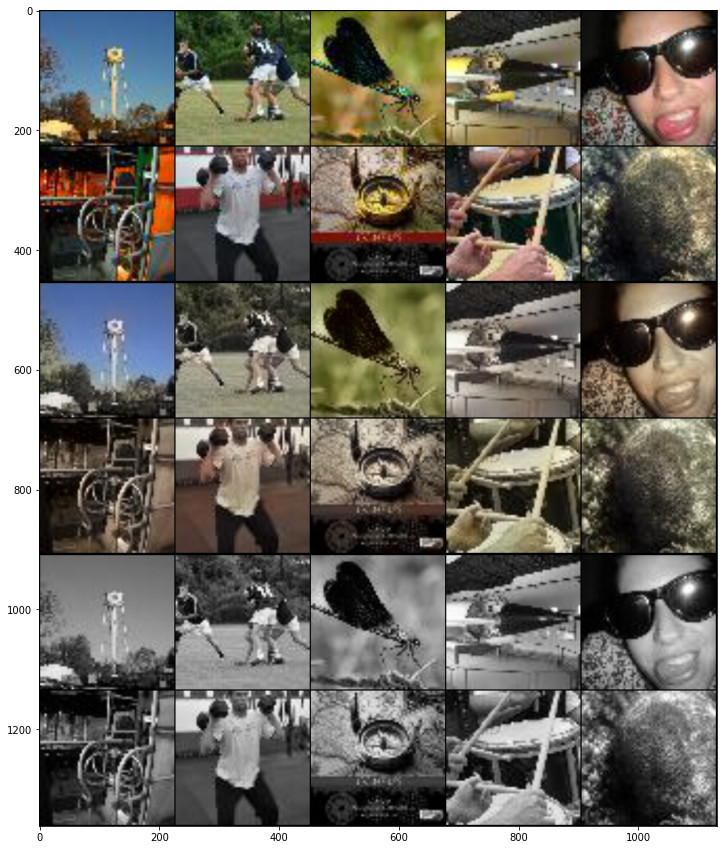

In [296]:
# grid visualize
mymodel.eval()
for i, (img, label) in enumerate(test_loader):
    if i == 0:
        lab_img = rgb_to_lab(img).float()
        L_channel = lab_img[:, 0:1, :, :]
        ab_channel = lab_img[:, 1:, :, :]

        gray_img = torch.cat([L_channel]*3, dim=1)

        gen_out_ab_channels, clf_logits = mymodel(gray_img)
        gen_out_img = torch.cat([L_channel, gen_out_ab_channels], dim=1)

        rgb_gen_out_img = lab_to_rgb(gen_out_img)
        
        gt = make_grid(img, nrow=5).detach().cpu().permute(1,2,0)
        output = make_grid(rgb_gen_out_img, nrow=5).detach().cpu().permute(1,2,0)
        grayscale = make_grid(gray_img, nrow=5).detach().cpu().permute(1,2,0)

        plt.figure(figsize=(15,15))
        plt.imshow(torch.cat([gt, output, grayscale], dim=0))
    else:
        break